In [1]:
import numpy as np
import pandas as pd

from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

import networkx as nx
import gurobipy as gp
from gurobipy import GRB

import time

import matplotlib.pyplot as plt
import seaborn as sns

import csv
import os

In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

from sklearn.metrics import (
    normalized_mutual_info_score,
    homogeneity_completeness_v_measure,
    fowlkes_mallows_score,
    adjusted_rand_score
)
from itertools import combinations

In [3]:
import warnings
warnings.filterwarnings('ignore')

## GCS-Q Algorithm

In [4]:
# Step 1: Construct the initial graph from the adjacency matrix
def construct_graph(adj_matrix):
    G = nx.Graph()
    num_nodes = len(adj_matrix)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i][j] != 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])
    return G

# Step 2: Define the function to calculate coalition value (sum of weights)
def coalition_value(subgraph):
    return subgraph.size(weight='weight')


def get_qubo_matrix(W):
    """Computes the QUBO matrix for the Minimum Cut problem given a weight matrix W."""
    n = W.shape[0]  # Number of nodes
    Q = np.zeros((n, n))  # Initialize QUBO matrix
    
    for i in range(n):
        Q[i, i] = np.sum(W[i])  # Diagonal terms (degree of node)
        for j in range(n):
            if i != j:
                Q[i, j] = -W[i, j]  # Off-diagonal terms (negative adjacency)
    
    return Q

# Step 3: Bipartitioning using QUBO and Quantum Annealing
def bipartition(graph):
    if len(graph.nodes())==1:
       return [], [0], 0

    w = nx.adjacency_matrix(graph).todense()
    qubo = get_qubo_matrix(W = w)

    bqm = BinaryQuadraticModel.from_qubo(qubo)

    sampler = EmbeddingComposite(DWaveSampler(token = open('dwave-api-token.txt','r').read(), solver={'topology__type': 'pegasus'}))
    sampleset = sampler.sample(bqm, num_reads=1000)
    qpu_access_time = sampleset.info['timing']['qpu_access_time']

    solution = sampleset.first.sample
    partition1 = [node for node in solution if solution[node] == 1]
    partition2 = [node for node in solution if solution[node] == 0]

    return partition1, partition2, qpu_access_time

def gurobi_qubo_solver_old(linear,quadratic):
    qubo_matrix = np.zeros([len(linear),len(linear)])
    for key,value in linear.items():
        qubo_matrix[int(key),int(key)] = value
    for key,value in quadratic.items():
        qubo_matrix[int(key[0]),int(key[1])] = value/2
        qubo_matrix[int(key[1]),int(key[0])] = value/2
    n = qubo_matrix.shape[0]
    model = gp.Model()
    x = model.addVars(n, vtype=GRB.BINARY)
    obj_expr = gp.quicksum(qubo_matrix[i, j] * x[i] * x[j] for i in range(n) for j in range(n))
    model.setObjective(obj_expr)
    model.setParam('OutputFlag', 0)
    model.optimize()
    if model.status == GRB.OPTIMAL:
        solution = [int(x[i].X) for i in range(n)]
        binary_string = ''.join(str(bit) for bit in solution)
        return binary_string, model.objVal
    else:
        return None, None

def gurobi_qubo_solver(qubo_matrix):
    n = qubo_matrix.shape[0]
    model = gp.Model()
    x = model.addVars(n, vtype=GRB.BINARY)
    obj_expr = gp.quicksum(qubo_matrix[i, j] * x[i] * x[j] for i in range(n) for j in range(n))
    model.setObjective(obj_expr)
    model.setParam('OutputFlag', 0)
    model.optimize()
    if model.status == GRB.OPTIMAL:
        solution = [int(x[i].X) for i in range(n)]
        binary_string = ''.join(str(bit) for bit in solution)
        return binary_string, model.objVal
    else:
        return None, None

# Step 3: Bipartitioning using QUBO and Quantum Annealing
def bipartition_gurobi(graph):
    if len(graph.nodes())==1:
       return [], [0]
    w = nx.adjacency_matrix(graph).todense()
    qubo = get_qubo_matrix(W = w)
    solution_str, objective_value = gurobi_qubo_solver(qubo)
    solution = {idx:int(bit) for idx,bit in enumerate(solution_str)}
    partition1 = [node for node in solution if solution[node] == 1]
    partition2 = [node for node in solution if solution[node] == 0]

    return partition1, partition2


# Step 4: Iterative GCS-Q Algorithm
def gcs_q_algorithm(adj_matrix, qubo_solver = "gurobi"):
    G = construct_graph(adj_matrix)
    grand_coalition = list(G.nodes)
    queue = [grand_coalition]
    CS_star = []
    total_qpu_access_time = 0
    total_partition_time = 0

    while queue:
        C = queue.pop(0)  # Dequeue the first coalition
        subgraph = G.subgraph(C).copy()

        # Solve the optimal split problem
        if qubo_solver == "dwave":
            t0 = time.time()
            partition1, partition2, qpu_access_time = bipartition(subgraph)
            partition_time = time.time() - t0
            # print("graph-size",len(subgraph.nodes()))
            # print("qpu_access_time",qpu_access_time)
            # print("partition_time",partition_time)
            total_qpu_access_time += qpu_access_time
            total_partition_time += partition_time
        else:
            partition1, partition2 = bipartition_gurobi(subgraph)
        partition1 = [C[subgraph_node_index] for subgraph_node_index in partition1]
        partition2 = [C[subgraph_node_index] for subgraph_node_index in partition2]

        if not partition2:  # If no meaningful split is found
            CS_star.append(partition1)
        elif not partition1:
            CS_star.append(partition2)
        else:  # If a meaningful split is found, enqueue the partitions
            queue.append(partition1)
            queue.append(partition2)

    return CS_star, total_qpu_access_time/10**6, total_partition_time

## PAM Algorithm

In [5]:
def calculate_total_cost(distance_matrix, medoids, clusters):
    total_cost = 0
    for medoid, cluster in zip(medoids, clusters):
        total_cost += np.sum(distance_matrix[cluster][:, medoid])
    return total_cost

def assign_clusters(distance_matrix, medoids):
    clusters = [[] for _ in range(len(medoids))]
    for i in range(distance_matrix.shape[0]):
        distances_to_medoids = [distance_matrix[i, medoid] for medoid in medoids]
        closest_medoid = np.argmin(distances_to_medoids)
        clusters[closest_medoid].append(i)
    return clusters

def pam(distance_matrix, k, max_iter=100):
    # Step 1: Initialize medoids
    medoids = np.random.choice(distance_matrix.shape[0], k, replace=False)
    best_medoids = medoids.copy()
    clusters = assign_clusters(distance_matrix, medoids)
    best_cost = calculate_total_cost(distance_matrix, medoids, clusters)
    
    for _ in range(max_iter):
        for medoid_idx in range(k):
            current_medoid = medoids[medoid_idx]
            non_medoids = [i for i in range(distance_matrix.shape[0]) if i not in medoids]
            
            for new_medoid in non_medoids:
                new_medoids = medoids.copy()
                new_medoids[medoid_idx] = new_medoid
                new_clusters = assign_clusters(distance_matrix, new_medoids)
                new_cost = calculate_total_cost(distance_matrix, new_medoids, new_clusters)
                
                if new_cost < best_cost:
                    best_cost = new_cost
                    best_medoids = new_medoids.copy()
                    clusters = new_clusters
                    
        if np.array_equal(best_medoids, medoids):
            break
        else:
            medoids = best_medoids.copy()
    
    return best_medoids, clusters

def clusters_as_set_of_sets(clusters):
    return [cluster for cluster in clusters]



## K-Means

In [6]:

def run_kmeans(adjacency_matrix, k, seed=None):
    from sklearn.manifold import MDS
    mds = MDS(n_components=2, dissimilarity='euclidean', random_state=seed)
    coords = mds.fit_transform(adjacency_matrix)
    
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=seed)
    labels = kmeans.fit_predict(coords)
    
    clusters = [[] for _ in range(k)]
    for idx, label in enumerate(labels):
        clusters[label].append(idx)
    return clusters

## Agglomerative Hierarchical

In [7]:
def run_hierarchical(adjacency_matrix, k):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(adjacency_matrix)
    
    clusters = [[] for _ in range(k)]
    for idx, label in enumerate(labels):
        clusters[label].append(idx)
    return clusters


## Spectral Clustering

In [8]:
def run_spectral(adjcency_matrix, k, seed=None):
    model = SpectralClustering(n_clusters=k, affinity='rbf', random_state=seed)
    labels = model.fit_predict(adjcency_matrix)
    
    clusters = [[] for _ in range(k)]
    for idx, label in enumerate(labels):
        clusters[label].append(idx)
    return clusters

## DIANA (Divisive Hierarchical)

In [9]:
import numpy as np

def diana(dist_matrix, k):
    n = dist_matrix.shape[0]
    clusters = [list(range(n))]

    while len(clusters) < k:
        # Select the cluster with the largest diameter
        diameters = [np.max(dist_matrix[np.ix_(c, c)]) for c in clusters]
        idx_to_split = np.argmax(diameters)
        cluster = clusters.pop(idx_to_split)

        # 1. Find point most dissimilar to all others
        avg_dists = np.mean(dist_matrix[np.ix_([i for i in cluster], [j for j in cluster])], axis=1)
        split_seed_idx = cluster[np.argmax(avg_dists)]
        new_cluster = [split_seed_idx]
        remaining = set(cluster) - {split_seed_idx}

        # 2. Move points one by one to new cluster if it decreases average dissimilarity
        for i in remaining:
            in_old = cluster.copy()
            in_old.remove(i)
            old_avg = np.mean([dist_matrix[i][j] for j in in_old])

            new_avg = np.mean([dist_matrix[i][j] for j in new_cluster])
            if new_avg < old_avg:
                new_cluster.append(i)
            else:
                in_old.append(i)

        old_cluster = list(set(cluster) - set(new_cluster))
        if old_cluster: clusters.append(old_cluster)
        if new_cluster: clusters.append(new_cluster)

    return clusters


## Utility functions

In [10]:
def clusters_to_labels(cluster_list, n_nodes):
    labels = np.zeros(n_nodes, dtype=int)
    for i, cluster in enumerate(cluster_list):
        for node in cluster:
            labels[node] = i
    return labels

In [11]:
def check_and_prepare_csv(report_filename_csv, fieldnames):
    if os.path.exists(report_filename_csv):
        with open(report_filename_csv, mode='r', newline='') as report_file:
            reader = csv.reader(report_file)
            existing_header = next(reader, None)

        if existing_header == fieldnames:
            print("✅ File exists. Headers match. Will start appending.")
        else:
            raise ValueError(
                f"❌ File '{report_filename_csv}' exists but headers do not match.\n"
                f"Expected: {fieldnames}\nFound:    {existing_header}"
            )
    else:
        with open(report_filename_csv, mode='w', newline='') as report_file:
            writer = csv.DictWriter(report_file, fieldnames=fieldnames)
            writer.writeheader()
        print("✅ File created and header written.")

#### Loading the Dataset

In [12]:
import scipy.io
import numpy as np

In [13]:
# Load the dataset (replace with the path to your file)
data = scipy.io.loadmat(r'hyspectral_data\KSC.mat')  # or use the actual file path
# data = scipy.io.loadmat(r'hyspectral_data\PaviaU.mat')  # or use the actual file path
# data = scipy.io.loadmat(r'hyspectral_data\Salinas.mat')  # or use the actual file path
# data = scipy.io.loadmat(r'hyspectral_data\Indian_pines.mat')  # or use the actual file path

In [14]:
# data.keys()

In [15]:
# Extract the hyperspectral data
hyperspectral_data = data['KSC']
# hyperspectral_data = data['paviaU']
# hyperspectral_data = data['salinas']
# hyperspectral_data = data['indian_pines']

# Check the shape of the data (it should be of the form [rows, columns, bands])
print(hyperspectral_data.shape)


(512, 614, 176)


#### Reshaping the Data

In [16]:
# Reshape the hyperspectral data into (num_pixels, num_bands)
num_pixels = hyperspectral_data.shape[0] * hyperspectral_data.shape[1]
num_bands = hyperspectral_data.shape[2]

# Reshaping data into (num_pixels, num_bands)
reshaped_data = hyperspectral_data.reshape((num_pixels, num_bands))

# Optionally, normalize the data (if needed)
reshaped_data = reshaped_data / np.max(reshaped_data, axis=0)  # Normalize each band
reshaped_data.shape

(314368, 176)

#### Calculating the Correlation Between Bands

In [17]:
# Calculate the correlation matrix between the bands
correlation_matrix = np.corrcoef(reshaped_data, rowvar=False)

# Display the correlation matrix
print(correlation_matrix)

[[ 1.         -0.16125362 -0.01149784 ...  0.08427149  0.08006247
   0.07908289]
 [-0.16125362  1.          0.14267673 ... -0.11088195 -0.08676079
  -0.10713964]
 [-0.01149784  0.14267673  1.         ... -0.01621152 -0.012786
  -0.01565754]
 ...
 [ 0.08427149 -0.11088195 -0.01621152 ...  1.          0.34746325
   0.36874102]
 [ 0.08006247 -0.08676079 -0.012786   ...  0.34746325  1.
   0.34535466]
 [ 0.07908289 -0.10713964 -0.01565754 ...  0.36874102  0.34535466
   1.        ]]


In [18]:
def get_correlation_matrix(dataset):
    data = scipy.io.loadmat(rf'hyspectral_data\{dataset}.mat')  # or use the actual file path
    hyperspectral_data = data[dataset]
    num_pixels = hyperspectral_data.shape[0] * hyperspectral_data.shape[1]
    num_bands = hyperspectral_data.shape[2]
    reshaped_data = hyperspectral_data.reshape((num_pixels, num_bands))
    reshaped_data = reshaped_data / np.max(reshaped_data, axis=0)  # Normalize each band
    correlation_matrix = np.corrcoef(reshaped_data, rowvar=False)
    return correlation_matrix

#### Metrics

In [19]:
def signed_modularity(adj_matrix, clusters):
    total_weight = np.sum(np.abs(adj_matrix)) / 2
    modularity = 0
    for cluster in clusters:
        for i, j in combinations(cluster, 2):
            modularity += adj_matrix[i, j]
    return modularity / total_weight

def penalty_metric(adj_matrix, clusters):
    penalty = 0
    for cluster in clusters:
        for i, j in combinations(cluster, 2):
            if adj_matrix[i, j] < 0:  # Penalize intra-cluster negative edges
                penalty += abs(adj_matrix[i, j])
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            if i != j and adj_matrix[i, j] > 0:  # Penalize inter-cluster positive edges
                in_same_cluster = any(i in cluster and j in cluster for cluster in clusters)
                if not in_same_cluster:
                    penalty += adj_matrix[i, j]
    return penalty




#### Find Optimal k

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_k(adjacency_matrix, max_k=10):
    distortions = []
    silhouette_scores = []
    k_values = range(2, max_k + 1)

    for k in k_values:
        clusters = run_kmeans(adjacency_matrix, k)
        labels = clusters_to_labels(clusters, len(adjacency_matrix))
        distortions.append(sum(np.min(adjacency_matrix, axis=1)))
        silhouette_scores.append(silhouette_score(adjacency_matrix, labels))

    # # Plot the Elbow Method
    # plt.figure(figsize=(10, 5))
    # plt.plot(k_values, distortions, 'bx-', label='Distortion')
    # plt.xlabel('Number of clusters (k)')
    # plt.ylabel('Distortion')
    # plt.title('Elbow Method for Optimal k')
    # plt.legend()
    # plt.show()

    # Return the k with the highest silhouette score
    optimal_k = k_values[np.argmax(silhouette_scores)]
    return optimal_k

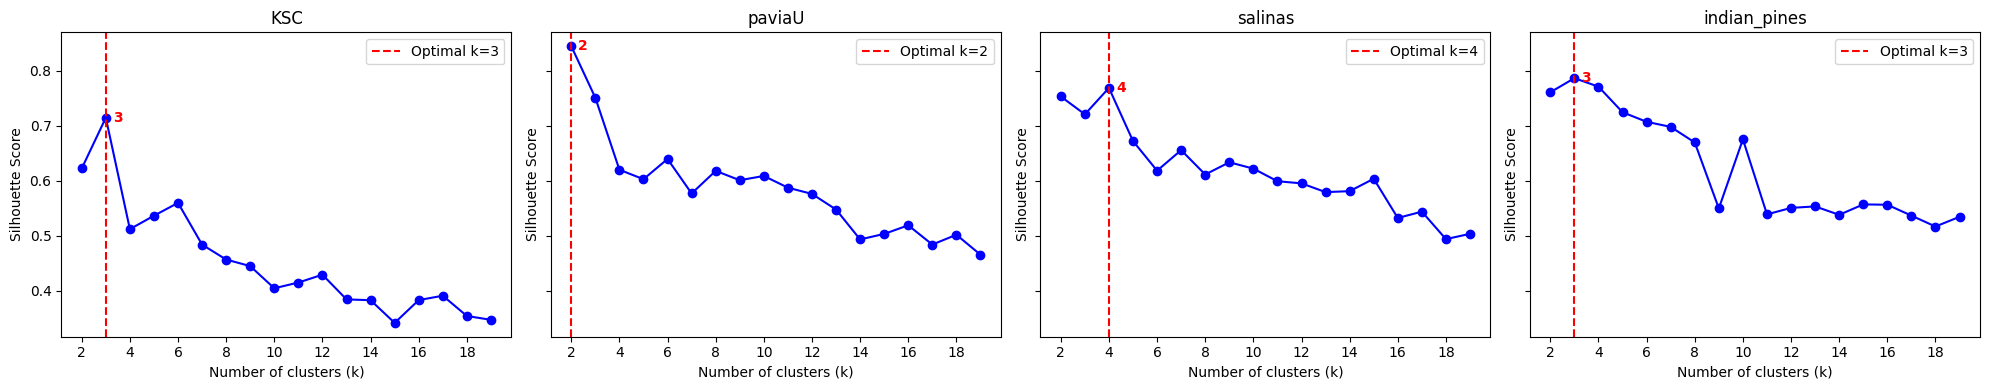

In [40]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

available_datasets = ['KSC', 'paviaU', 'salinas', 'indian_pines']
all_silhouette_scores = []
all_k_values = []
all_optimal_k = []

for dataset in available_datasets:
    correlation_matrix = get_correlation_matrix(dataset)
    # max_k = correlation_matrix.shape[0]
    max_k = 20
    k_values = range(2, max_k)
    silhouette_scores = []
    for k in k_values:
        clusters = run_kmeans(correlation_matrix, k)
        labels = clusters_to_labels(clusters, len(correlation_matrix))
        silhouette_scores.append(silhouette_score(correlation_matrix, labels))
    all_silhouette_scores.append(silhouette_scores)
    all_k_values.append(list(k_values))
    all_optimal_k.append(k_values[np.argmax(silhouette_scores)])

# Plot all silhouette scores as subplots
fig, axes = plt.subplots(1, len(available_datasets), figsize=(5 * len(available_datasets), 4), sharey=True)
if len(available_datasets) == 1:
    axes = [axes]
for idx, dataset in enumerate(available_datasets):
    axes[idx].plot(all_k_values[idx], all_silhouette_scores[idx], 'o-', color='b')
    axes[idx].set_title(dataset)
    axes[idx].set_xlabel('Number of clusters (k)')
    axes[idx].set_ylabel('Silhouette Score')
    axes[idx].axvline(all_optimal_k[idx], color='r', linestyle='--', label=f'Optimal k={all_optimal_k[idx]}')
    # Annotate the red line with its value
    axes[idx].annotate(f'{all_optimal_k[idx]}', 
                       xy=(all_optimal_k[idx], max(all_silhouette_scores[idx])), 
                       xytext=(5, 0), textcoords='offset points',
                       color='red', fontsize=10, fontweight='bold',
                       va='center', ha='left', rotation=0)
    axes[idx].legend()
    # Set x-ticks to even numbers only
    even_ticks = [k for k in all_k_values[idx] if k % 2 == 0]
    axes[idx].set_xticks(even_ticks)
plt.tight_layout()
plt.show()


In [ ]:
# available_datasets = ['KSC', 'paviaU', 'salinas', 'indian_pines']
available_datasets = ['KSC', 'paviaU', 'salinas', 'indian_pines']

for dataset in available_datasets:

    correlation_matrix = get_correlation_matrix(dataset)

    # optimal_k = find_optimal_k(correlation_matrix, dataset, max_k=correlation_matrix.shape[0])
    optimal_k = find_optimal_k(correlation_matrix, dataset, max_k=10)
    
    print(f"Optimal k for {dataset}: {optimal_k}")

#### Correlation Clustering

In [44]:
solvers = ["GCSQ", "PAM", "DIANA", "KMeans", "Hier", "Spectral"]
solvers = ["DIANA"]

In [ ]:
import csv

results_file = r'results/results_EO.csv'
fieldnames = ['Dataset', 'Solver', 'Modularity', 'Penalty']

# Ensure the CSV file has the correct headers
with open(results_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

available_datasets = ['KSC', 'paviaU', 'salinas', 'indian_pines']
optimal_k = [3,2,4,3]

for dataset, n_clusters in zip(available_datasets, optimal_k):

    correlation_matrix = get_correlation_matrix(dataset)

    if "GCSQ" in solvers:
        clusters_gcsq, total_qpu_access_time, total_partition_time = gcs_q_algorithm(correlation_matrix)
        clusters = sorted([sorted(cluster) for cluster in clusters_gcsq])
        modularity = signed_modularity(correlation_matrix, clusters)
        penalty = penalty_metric(correlation_matrix, clusters)
        with open(results_file, mode='a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writerow({'Dataset': dataset, 'Solver': 'GCSQ', 'Modularity': modularity, 'Penalty': penalty})

    if "PAM" in solvers:
        alpha = 2
        distance_matrix = np.sqrt(alpha * (1 - correlation_matrix.clip(min=-1, max=1)))
        _, clusters = pam(distance_matrix, k=n_clusters)
        clusters = sorted([sorted(cluster) for cluster in clusters])
        modularity = signed_modularity(correlation_matrix, clusters)
        penalty = penalty_metric(correlation_matrix, clusters)
        with open(results_file, mode='a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writerow({'Dataset': dataset, 'Solver': 'PAM', 'Modularity': modularity, 'Penalty': penalty})

    if "KMeans" in solvers:
        clusters = sorted([sorted(cluster) for cluster in run_kmeans(correlation_matrix, k=n_clusters, seed=42)])
        modularity = signed_modularity(correlation_matrix, clusters)
        penalty = penalty_metric(correlation_matrix, clusters)
        with open(results_file, mode='a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writerow({'Dataset': dataset, 'Solver': 'KMeans', 'Modularity': modularity, 'Penalty': penalty})

    if "Hier" in solvers:
        clusters = sorted([sorted(cluster) for cluster in run_hierarchical(correlation_matrix, k=n_clusters)])
        modularity = signed_modularity(correlation_matrix, clusters)
        penalty = penalty_metric(correlation_matrix, clusters)
        with open(results_file, mode='a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writerow({'Dataset': dataset, 'Solver': 'Hier', 'Modularity': modularity, 'Penalty': penalty})

    if "Spectral" in solvers:
        clusters = sorted([sorted(cluster) for cluster in run_spectral(correlation_matrix, k=n_clusters, seed=42)])
        modularity = signed_modularity(correlation_matrix, clusters)
        penalty = penalty_metric(correlation_matrix, clusters)
        with open(results_file, mode='a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writerow({'Dataset': dataset, 'Solver': 'Spectral', 'Modularity': modularity, 'Penalty': penalty})

    if "DIANA" in solvers:
        alpha = 2
        distance_matrix = np.sqrt(alpha * (1 - correlation_matrix.clip(min=-1, max=1)))
        clusters = sorted([sorted(cluster) for cluster in diana(distance_matrix, k=n_clusters)])
        modularity = signed_modularity(correlation_matrix, clusters)
        penalty = penalty_metric(correlation_matrix, clusters)
        with open(results_file, mode='a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writerow({'Dataset': dataset, 'Solver': 'DIANA', 'Modularity': modularity, 'Penalty': penalty})

#### Visualizations


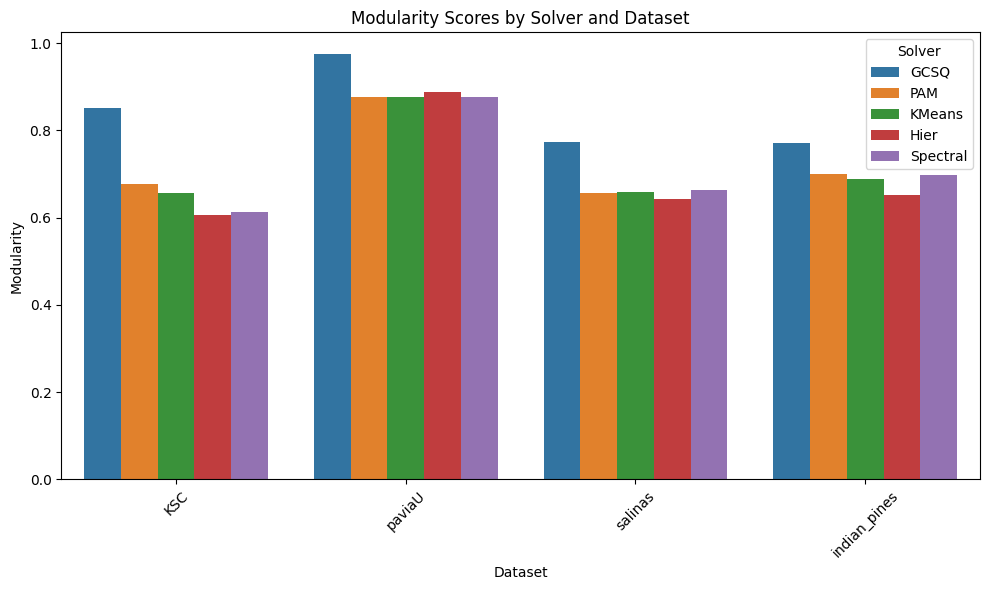

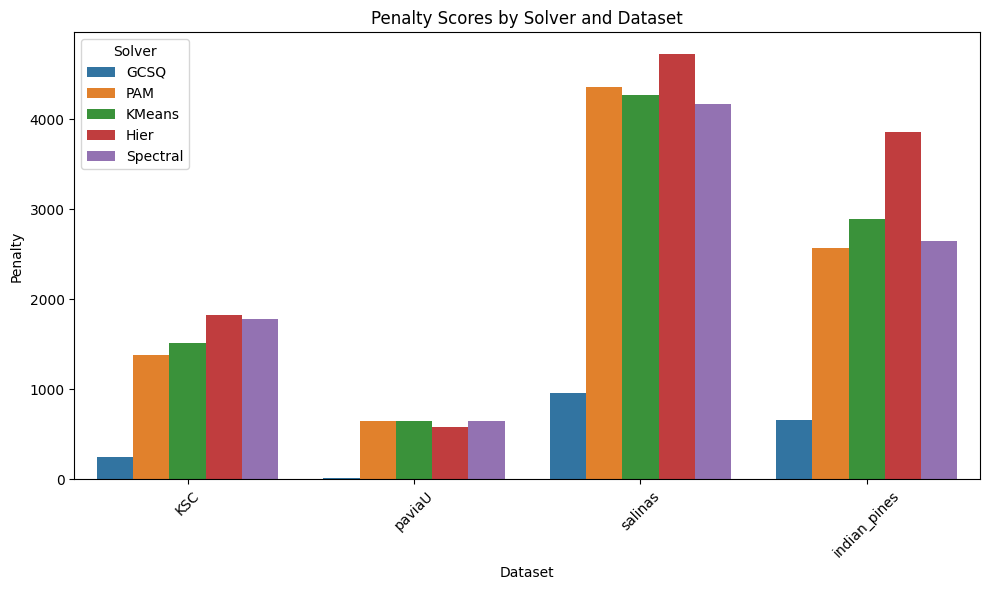

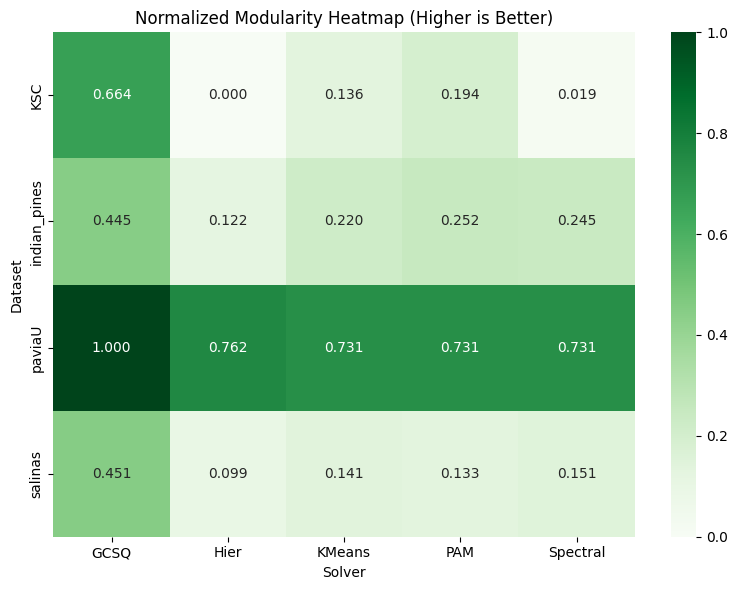

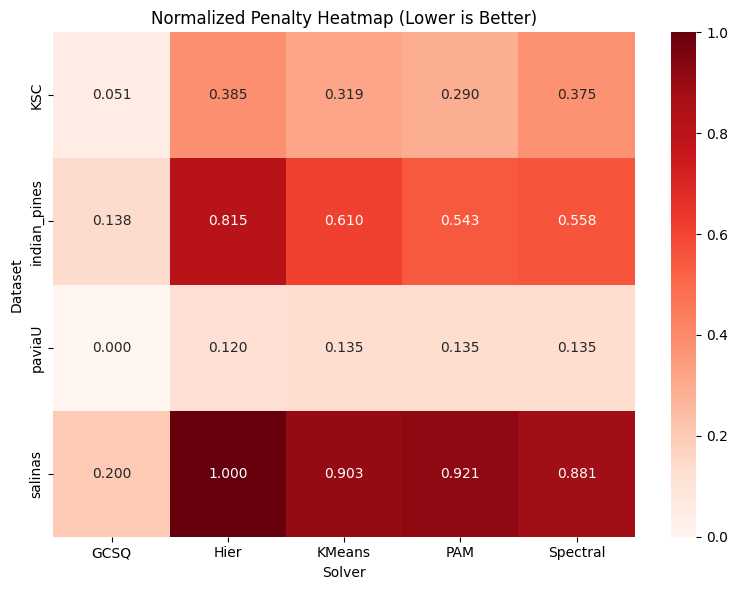

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the results from the CSV file
results_df = pd.read_csv('results_EO.csv')

# Normalize a DataFrame
def normalize(df):
    return (df - df.min().min()) / (df.max().max() - df.min().min())

# Bar plot for Modularity
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Dataset', y='Modularity', hue='Solver')
plt.title('Modularity Scores by Solver and Dataset')
plt.ylabel('Modularity')
plt.xlabel('Dataset')
plt.legend(title='Solver')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for Penalty
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Dataset', y='Penalty', hue='Solver')
plt.title('Penalty Scores by Solver and Dataset')
plt.ylabel('Penalty')
plt.xlabel('Dataset')
plt.legend(title='Solver')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap for Modularity
modularity_pivot = results_df.pivot_table(index='Dataset', columns='Solver', values='Modularity')
modularity_normalized = normalize(modularity_pivot)
plt.figure(figsize=(8, 6))
sns.heatmap(modularity_normalized, annot=True, cmap='Greens', fmt='.3f')
plt.title('Normalized Modularity Heatmap (Higher is Better)')
plt.ylabel('Dataset')
plt.xlabel('Solver')
plt.tight_layout()
plt.show()

# Heatmap for Penalty
penalty_pivot = results_df.pivot_table(index='Dataset', columns='Solver', values='Penalty')
penalty_normalized = normalize(penalty_pivot)
plt.figure(figsize=(8, 6))
sns.heatmap(penalty_normalized, annot=True, cmap='Reds', fmt='.3f')
plt.title('Normalized Penalty Heatmap (Lower is Better)')
plt.ylabel('Dataset')
plt.xlabel('Solver')
plt.tight_layout()
plt.show()

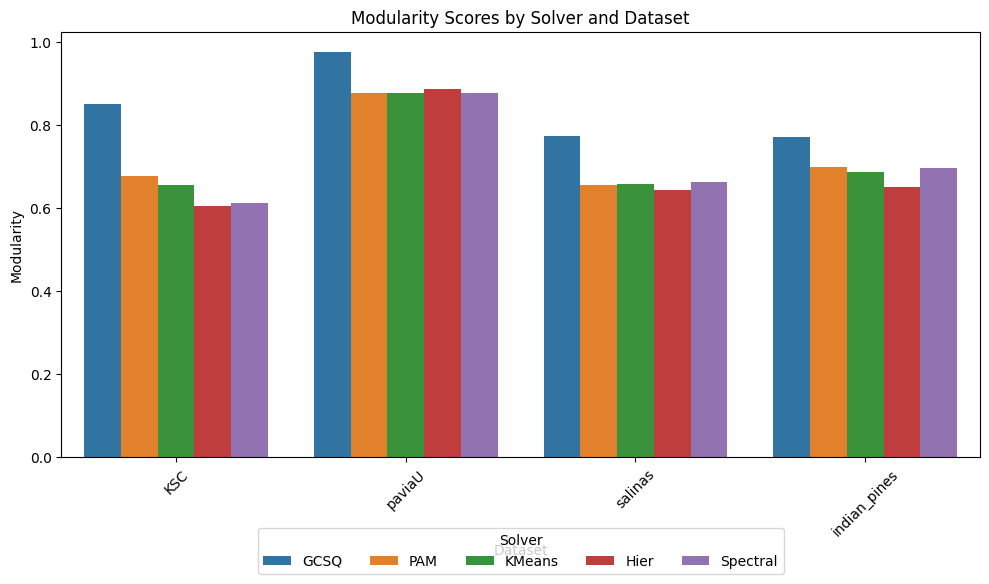

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the results from the CSV file
results_df = pd.read_csv('results_EO.csv')

# Normalize a DataFrame
def normalize(df):
    return (df - df.min().min()) / (df.max().max() - df.min().min())


# Bar plot for Modularity
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Dataset', y='Modularity', hue='Solver')
plt.title('Modularity Scores by Solver and Dataset')
plt.ylabel('Modularity')
plt.xlabel('Dataset')
plt.legend(title='Solver', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()